# Pasos seguidos para crear una trayectoria

In [26]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1- Preparar el espacio de trabajo

In [86]:
img_size = np.array((1920,1080))

origen = np.array((420,585))
destino = np.array((1495, 585))

max_deviation = 0.5
n_steps = 90

noisiness = 0.9
max_noise_deviation = 0.6

In [77]:
def show_plot(points):
    bg = plt.imread("resources/background.png")
    fig, ax = plt.subplots(figsize=(40, 60), dpi=60)
    ax.imshow(bg, extent=[0, 1920, 1080, 0])
    ax.plot(points[:,0], points[:,1], marker='o', color='lime', linewidth=6, markersize=20)
    ax.axis("off")
    plt.show()

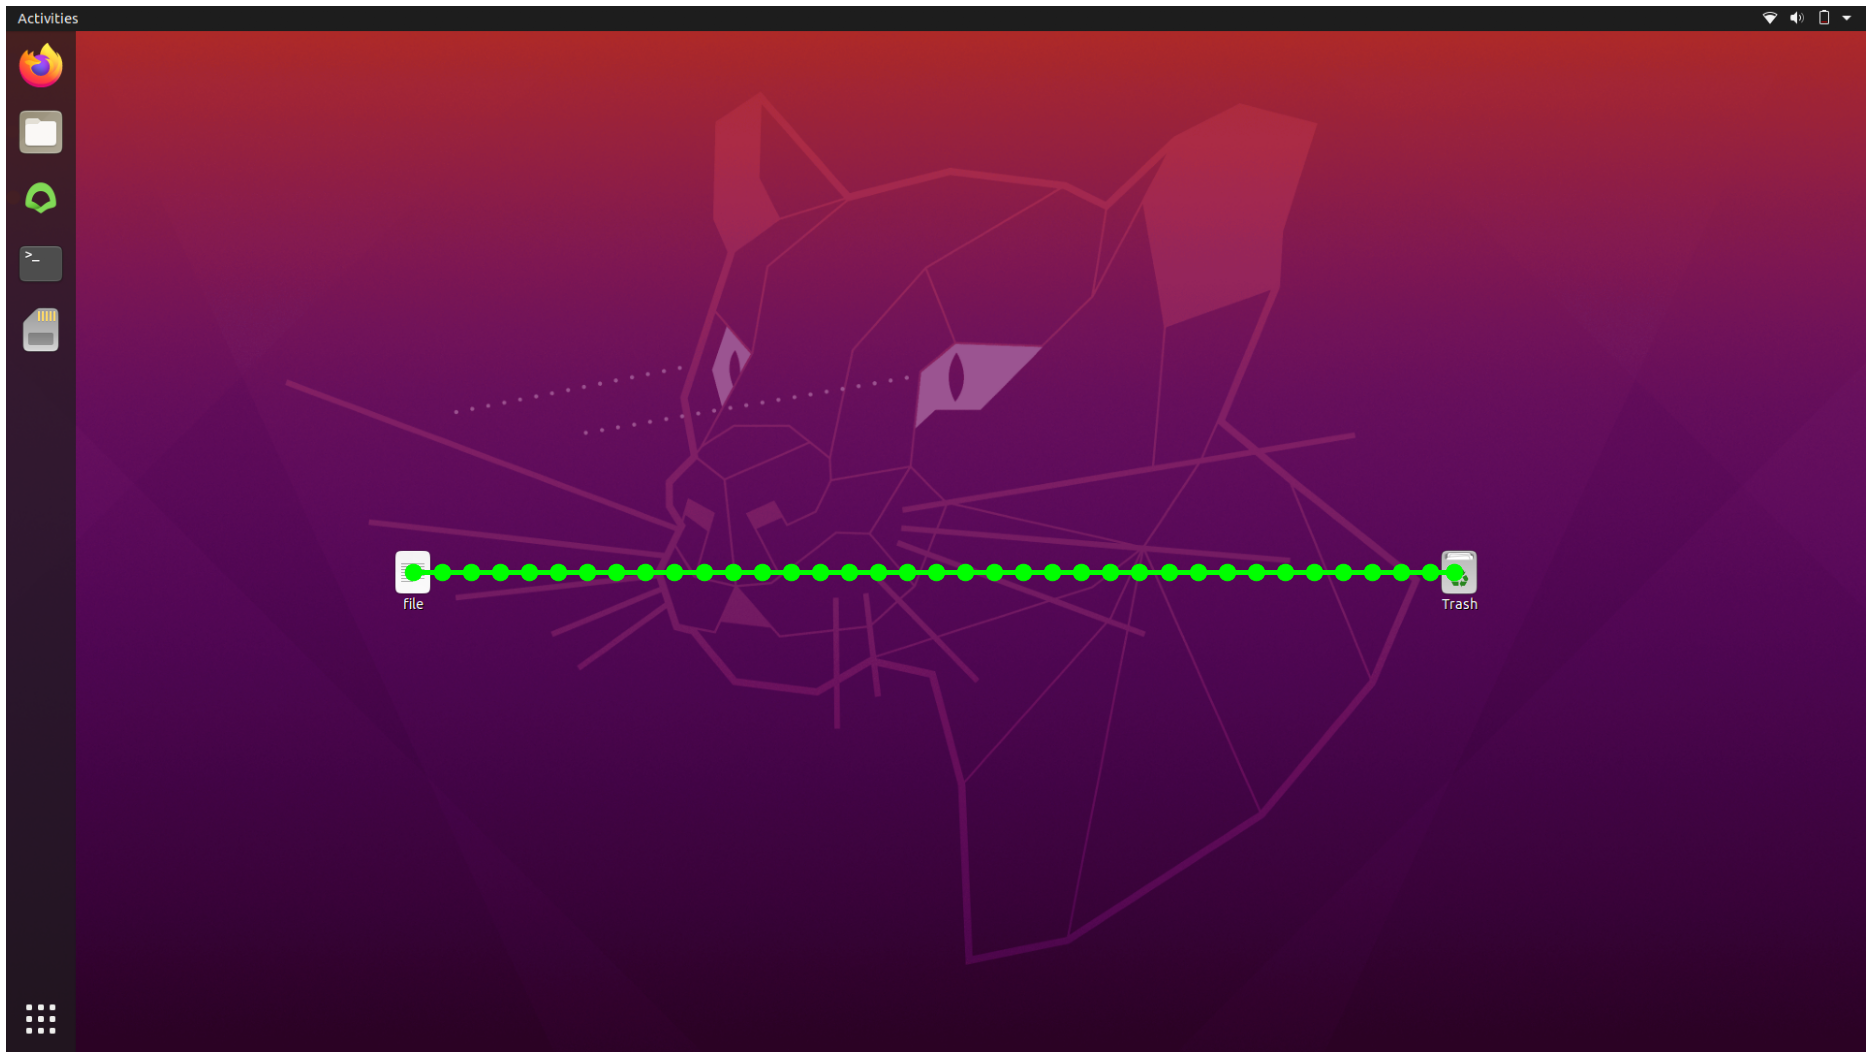

In [78]:
# Example
p = abs(destino[1]-origen[1])/abs(destino[0]-origen[0])
mult_x = np.sign(destino[0]-origen[0])
mult_y = np.sign(destino[1]-origen[1])

points_line = []
for step in range(0, abs(origen[0] - destino[0]), 30):
    points_line.append((origen[0] + mult_x*step, origen[1] + mult_y*step*p))
points_line.append(destino)
points_line = np.array(points_line)

show_plot(points_line)

## 2- Generar puntos de control de la curva

In [79]:
# Usamos el mismo seed para generar resultados consistentes
np.random.seed(12345)

In [80]:
# Convertimos todos los puntos a intervalos entre 0-1
# Re nombramos los puntos de origen y destino
p_0 = np.array([origen[0]/img_size[0], origen[1]/img_size[1]])
p_3 = np.array([destino[0]/img_size[0], destino[1]/img_size[1]])

# Escogemos dos puntos aleatorios como puntos de control de la curva
rand = max_deviation - np.random.uniform() * max_deviation * 2
rand2 = max_deviation - np.random.uniform() * max_deviation * 2
p_1 = p_0 + np.array([rand, rand2])

rand = max_deviation - np.random.uniform() * max_deviation * 2
rand2 = max_deviation - np.random.uniform() * max_deviation * 2
p_2 = p_3 + np.array([rand, rand2])

In [81]:
print('''
Curva dada por los siguientes puntos de control:
P_0 = [{}-{}]
P_1 = [{}-{}]
P_2 = [{}-{}]
P_3 = [{}-{}]
'''.format(*p_0, *p_1, *p_2, *p_3))


Curva dada por los siguientes puntos de control:
P_0 = [0.21875-0.5416666666666666]
P_1 = [0.22494117679750902-0.7953965722488611]
P_2 = [1.1644778302715886-0.8758800373132746]
P_3 = [0.7786458333333334-0.5416666666666666]



## 3- Generar una curva con progresion lineal

In [82]:
points = []

# Calculamos la distribucion de puntos discretos de la curva
T = np.array(range(0, n_steps+1)) / n_steps

# Calculamos los puntos discretos
for t_i in T:
    t = t_i
    s_0 = p_0*(1-t)**3
    s_1 = 3 * p_1 * t * (1 - t)**2
    s_2 = 3 * p_2 * (1-t) * t**2
    s_3 = p_3 * t**3

    p = s_0 + s_1 + s_2 + s_3

    points.append(p)

points = np.array(points)

# Devolvemos al tamano de la imagen
points[:, 0] *= img_size[0]
points[:, 1] *= img_size[1]

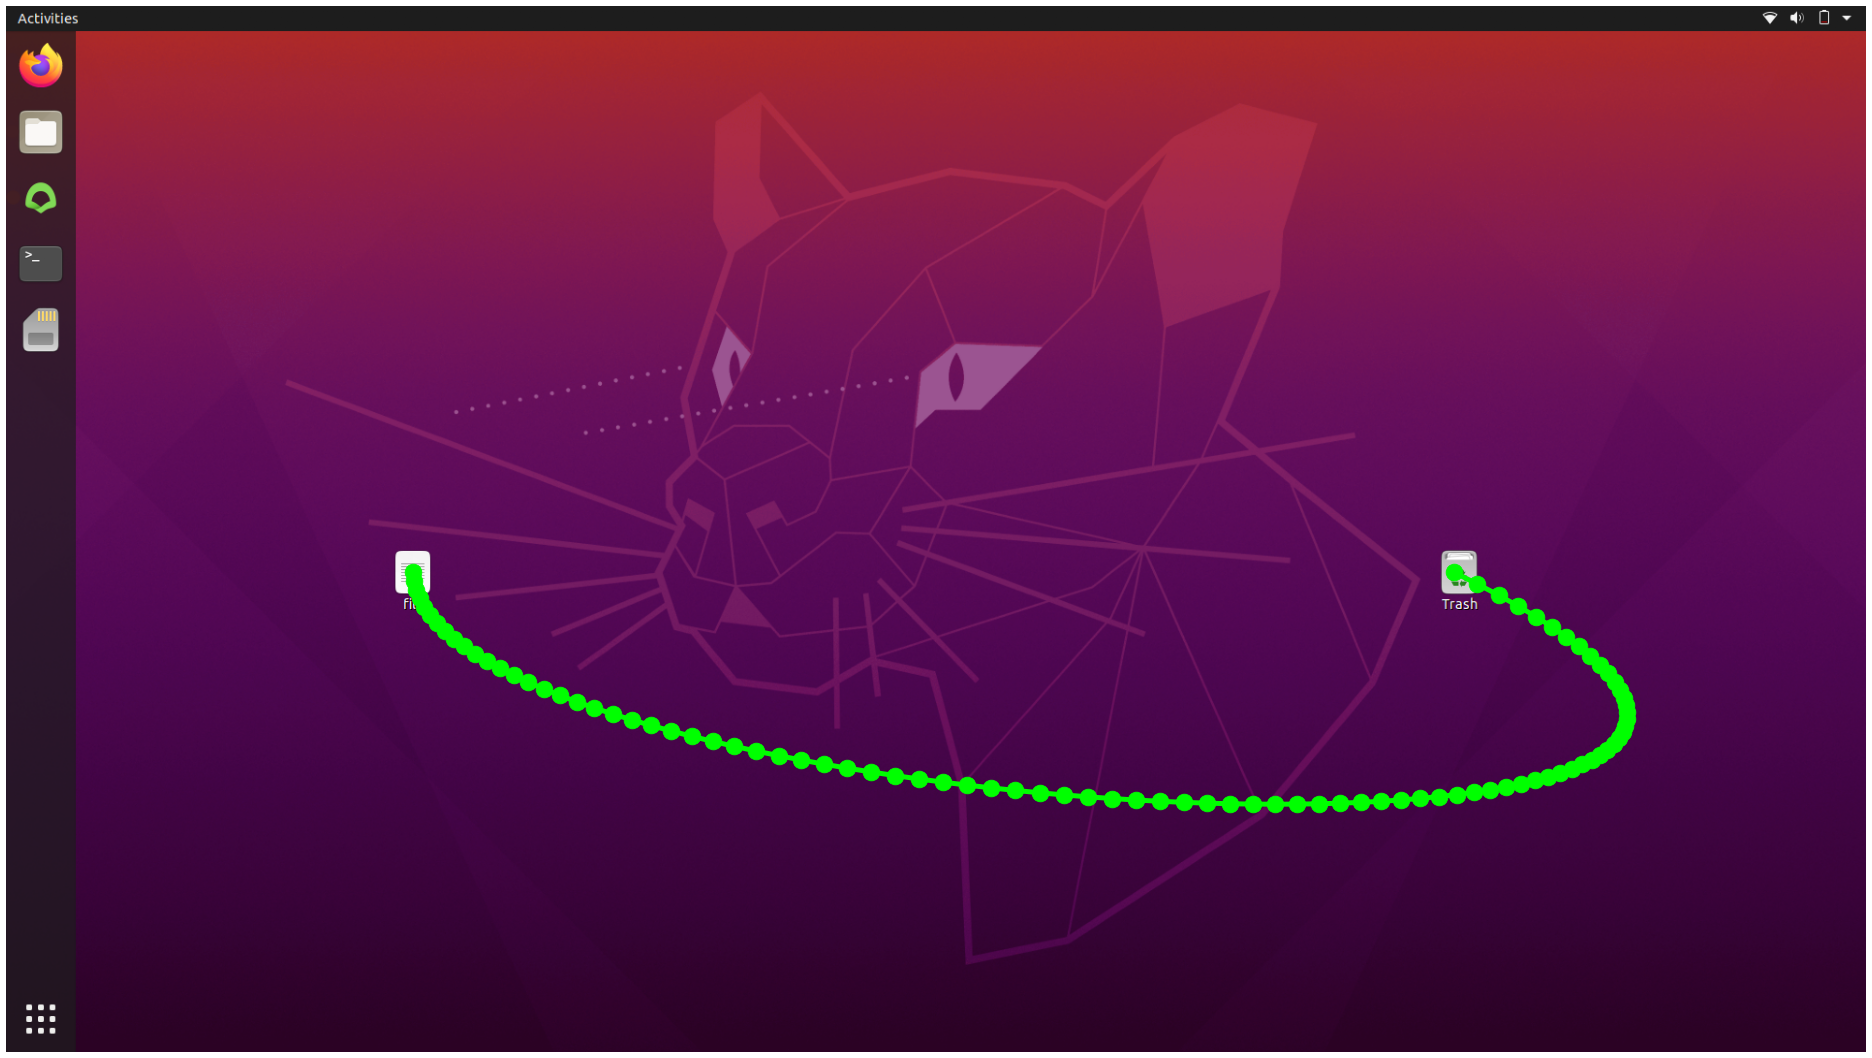

In [83]:
show_plot(points)

## 4- Generar una curva con progresion no lineal

In [84]:
points = []

# Calculamos la distribucion de puntos discretos de la curva
T = np.sort(np.random.triangular(0.0, np.random.uniform(0.9,1.), 1.0, n_steps))
T = np.insert(T, 0, 0, axis=0)
T = np.insert(T, len(T), 1, axis=0)

# Calculamos los puntos discretos
for t_i in T:
    t = t_i
    s_0 = p_0*(1-t)**3
    s_1 = 3 * p_1 * t * (1 - t)**2
    s_2 = 3 * p_2 * (1-t) * t**2
    s_3 = p_3 * t**3

    p = s_0 + s_1 + s_2 + s_3

    points.append(p)

points = np.array(points)

# Devolvemos al tamano de la imagen
points[:, 0] *= img_size[0]
points[:, 1] *= img_size[1]

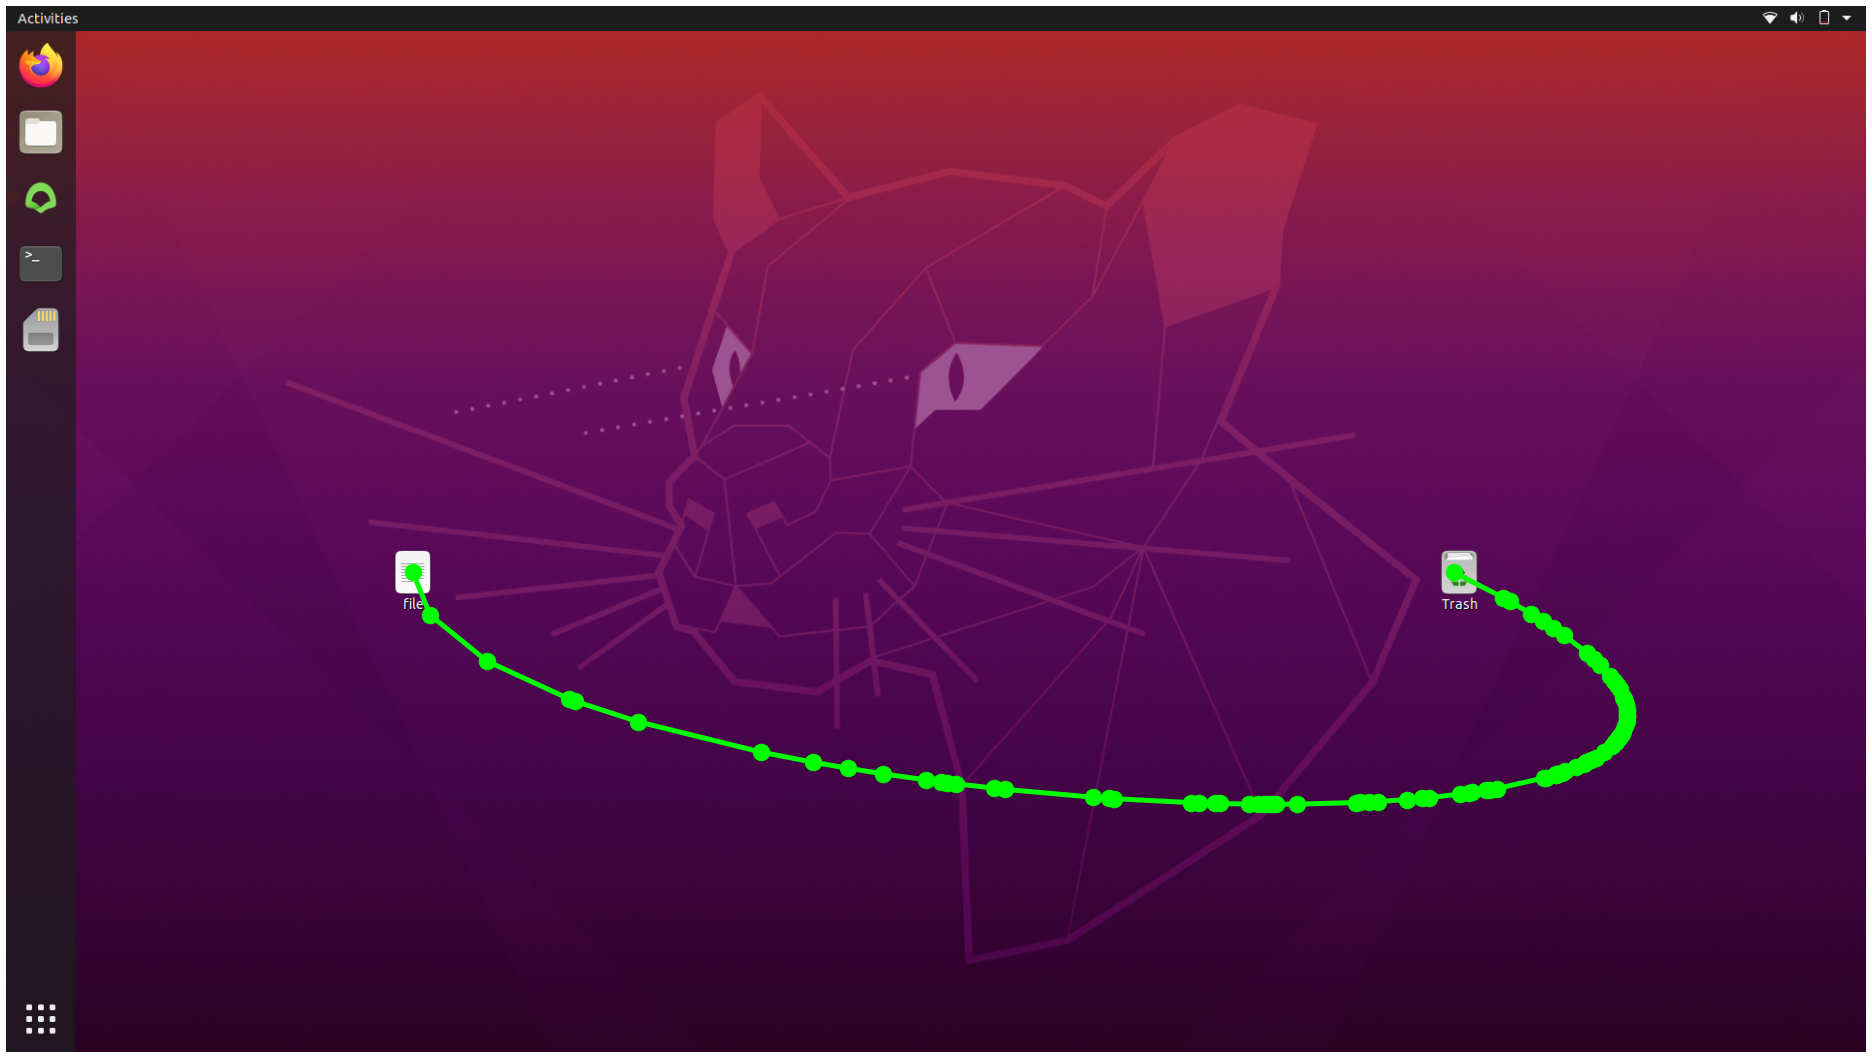

In [85]:
show_plot(points)

## 5- Generar ruido

In [89]:
# Calculate N points that we will create
n_noisy_points = int(len(points) * noisiness)

# Make it a pair number
n_noisy_points = n_noisy_points if n_noisy_points % 2 == 0 else n_noisy_points - 1

# Get a random set of points that we will add noise to
i_noisy_points = []
for _ in range(n_noisy_points):
    i = np.random.randint(1, len(points))

    # If we already took that index repeat
    while i in i_noisy_points:
        i = np.random.randint(1, len(points))

    i_noisy_points.append(i)

# Calculate the vectors leading to those points
vectors = []
for i in i_noisy_points:
    vectors.append(points[i] - points[i - 1])
vectors = np.array(vectors)

# Choose pairs of vectors
vs_1, vs_2 = np.split(vectors, 2)
is_1, is_2 = np.split(np.array(i_noisy_points), 2)
noise = np.zeros((len(points), 2))
for i_1, i_2, v_1, v_2 in zip(is_1, is_2, vs_1, vs_2):
    # Calculate max deviations
    max_x_deviation = abs(min(v_1[0], v_2[0]))
    max_y_deviation = abs(min(v_1[1], v_2[1]))

    max_x_deviation *= max_noise_deviation
    max_y_deviation *= max_noise_deviation

    # Calculate noise
    n = np.empty(2)
    n[0] = np.random.uniform(-max_x_deviation, max_x_deviation)
    n[1] = np.random.uniform(-max_y_deviation, max_y_deviation)

    # Add opposite noise to each
    noise[i_1] += n
    noise[i_2] -= n

new_points = []
noise_sum = np.zeros(2)
# delete the first point 
new_points.append(points[0])

# Recalculate points
for og_p, n in zip(points[1:], noise[1:]):
    noise_sum += n
    new_p = og_p + noise_sum
    new_points.append(new_p)
    
new_points = np.array(new_points)

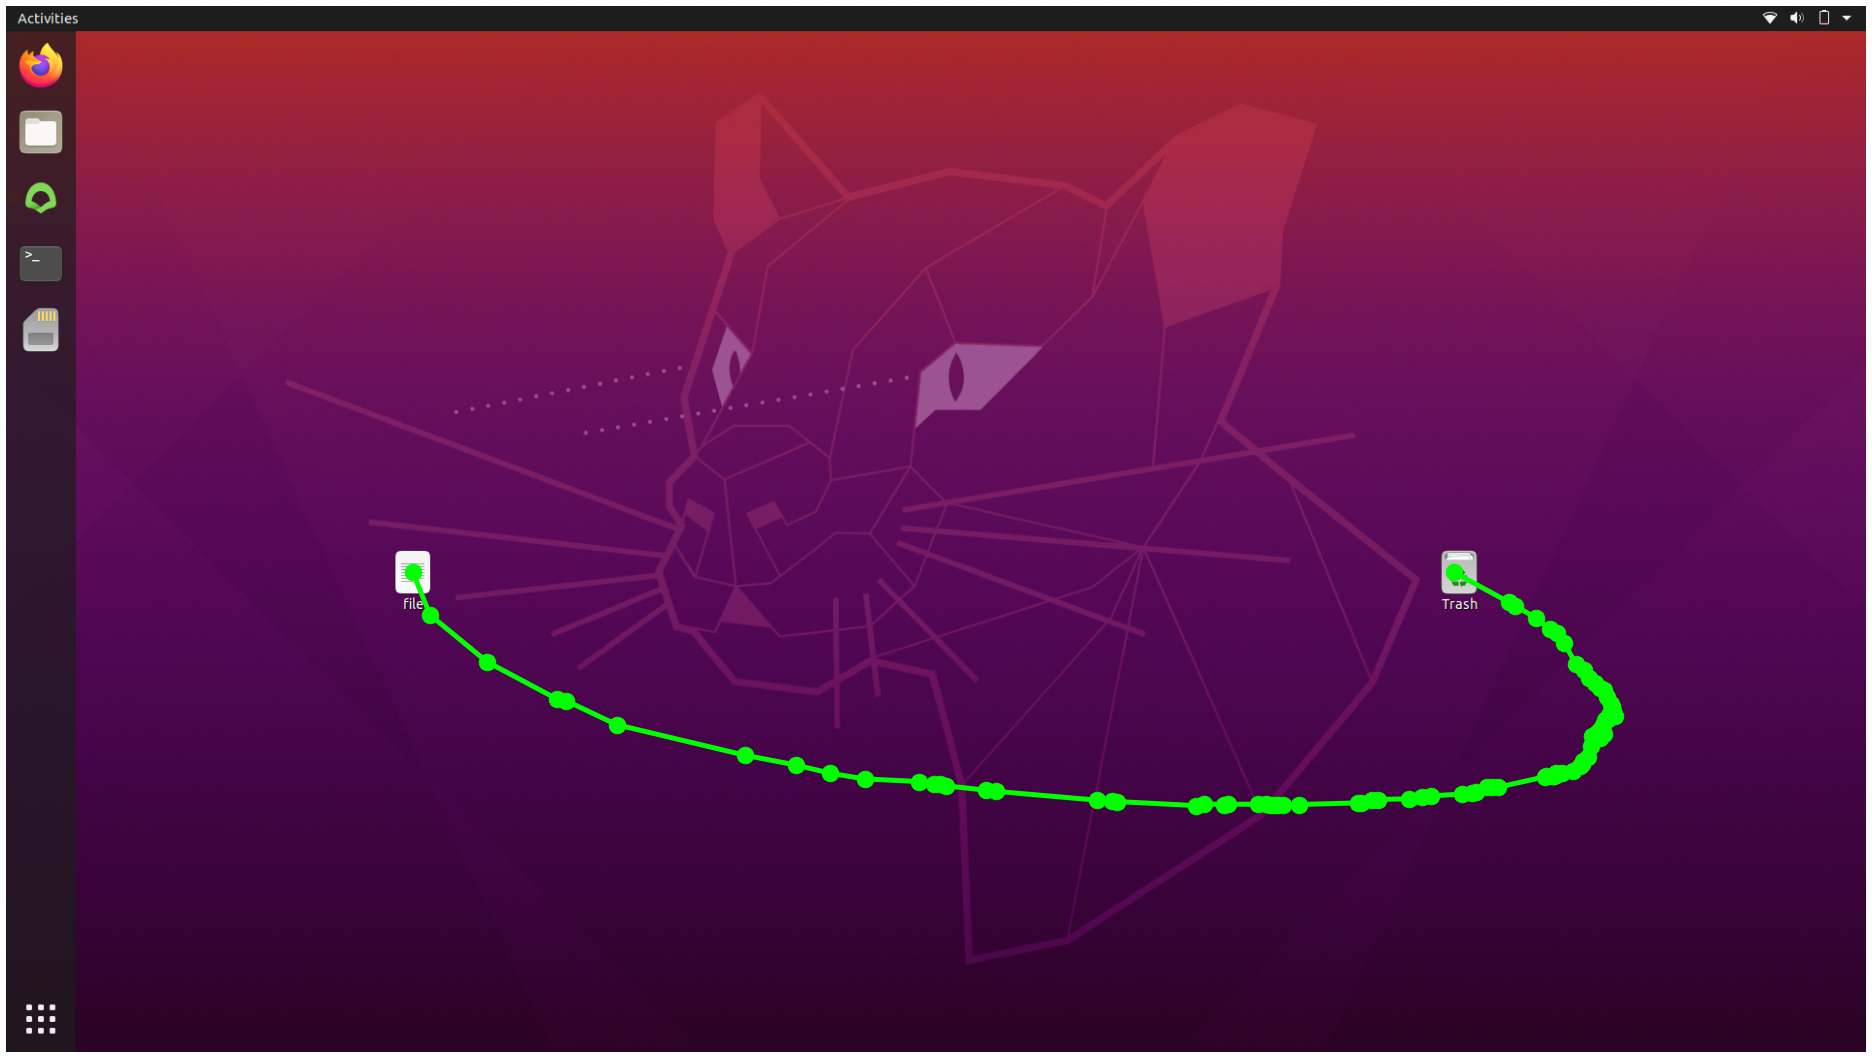

In [90]:
show_plot(new_points)